**MLP with TF-IDF**

✅ Loaded full dataset: (2331552, 2)


<ipython-input-1-8eec6ec378db>:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(50_000, random_state=42))


bias_label
center    50000
left      50000
right     50000
Name: count, dtype: int64


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(



🎯 Accuracy: 0.6999333333333333
              precision    recall  f1-score   support

      center       0.70      0.68      0.69     10000
        left       0.69      0.74      0.72     10000
       right       0.71      0.69      0.70     10000

    accuracy                           0.70     30000
   macro avg       0.70      0.70      0.70     30000
weighted avg       0.70      0.70      0.70     30000



/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


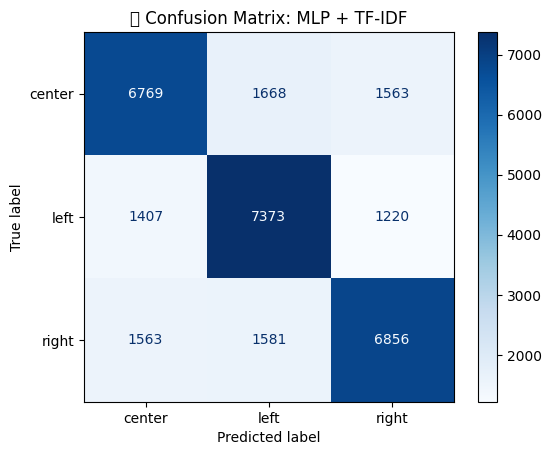

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load cleaned data
df = pd.read_parquet('/content/drive/MyDrive/NLP News Bias Data/df_cleaned_model_ready.parquet')
print(f"✅ Loaded full dataset: {df.shape}")

# Ensure balanced dataset by sampling 50k per class
df_balanced = (
    df.groupby('bias_label', group_keys=False)
      .apply(lambda g: g.sample(50_000, random_state=42))
      .reset_index(drop=True)
)

# Optional: check label distribution
print(df_balanced['bias_label'].value_counts())

# Split into text and labels
X_text = df_balanced['text_clean']
y = df_balanced['bias_label'].astype(str).tolist()  # ✅ fix here

# Split data BEFORE vectorizing to avoid leakage
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text, y, stratify=y, test_size=0.2, random_state=42
)

# Vectorization
vectorizer = TfidfVectorizer(max_features=20000)
X_train = vectorizer.fit_transform(X_train_text)
X_test = vectorizer.transform(X_test_text)

# Dense arrays
X_train_dense = np.nan_to_num(X_train.toarray().astype(np.float32))
X_test_dense = np.nan_to_num(X_test.toarray().astype(np.float32))

# Final check: ensure clean string arrays
y_train = np.array(y_train, dtype=str)
y_test = np.array(y_test, dtype=str)

# Train MLP
mlp = MLPClassifier(
    hidden_layer_sizes=(300,),
    activation='relu',
    max_iter=50,
    random_state=42
)
mlp.fit(X_train_dense, y_train)

# Evaluate
y_pred = mlp.predict(X_test_dense)
print("\n🎯 Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
plt.title("📊 Confusion Matrix: MLP + TF-IDF")
plt.show()